# Turkey

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

To do:
estimate r
figure out how to graph final sweep
    -5 different graphs?
    -snapshot ends?
    -display difference between inner and outer?
    -big table?
    -make colors match?
research ideal turkey temp


### From turkey cooking article:
http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf data from turkey
 118°C oven temp, with the oven at room temperature starting their experiment
 thermal conductivity 0.461 W/m K
 surface heat transfer coefficient of 19.252 W/m2K

### From thermal properities of food pdf (in google doc): 
Turkey specific heat above freezing 3.53 kJ/(kg·K)
Turkey, breast 0.496 W/(m·K) thermal conductivity at 3 degrees C

With the upcoming Thanksgiving season, the concern of cooking the perfect turkey is on many families’ minds.
If you cook a turkey at too high of an oven temperature, the outside cooks faster than the inside, and can cause burning or undercooking of the inside of the turkey. On the other hand, if you cook a turkey at too low an oven temperature, it takes a very long time to cook, and you do not get a good crispy outside. Also, if you cook a turkey for too little time you risk undercooking and if you cook a turkey for too long it can cause dryness and burning. It’s important to balance time and oven temperature in order to cook a good thanksgiving turkey, and so we wanted to explore the ideal factors.


## When cooking a 10 pound turkey, what is the best length of time to cook it for and best oven temperature to cook it at?

We modeled the turkey as a sphere made of two layers. The spherical turkey weighed 10 lbs and has a diameter of 30 centimeters -- both determined from online turkey recipes. The outer layer of the turkey was assumed to have a thickness of 3 cm. The heat of the oven was kept constant within a single run of the simulation, and heat was modeled to be transferred via conduction between the air of the oven and the outer layer of the turkey, and between the outer and inner layers.

In [176]:
def make_system(params, T_oven, T_init, t_end):
    """Make a system object for the turkey model.
    inner is inner temperature of turkey
    outer is outer temperature of turkey
    
    params is the r and C values for thermal compartments
    t_end is when the turkey is taken out of the oven
    )
    
    returns: System object
    """
    #initial temperatures are of the temperature of pre-heated oven
    init = State(T_inner=T_init, T_outer=T_init)

    return System(init=init, t0=0, t_end=t_end, T_oven=T_oven,
                  params = params)

To calculate the temperature derivative with respect to time of the outer and inner layers (dodt and didt respectively), we used the formulas
Flux = (T_ext - T) / R
And
dT/dt = net flux/C
Where R = thermal resistivity and C = thermal mass.

The C value of each layer was estimated as the mass multiplied by the specific heat of turkey meat from ashrae.org's "Thermal Properties of Foods" and the R value was estimated so the temperature of the internal layer over time would match that of an actual turkey being cooked in this paper: http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf
https://www.researchgate.net/file.PostFileLoader.html?id=57dc0df6dc332d6c7a2b0e94&assetKey=AS%3A406964417908742%401474039286881



In [185]:
def slope_func(state, t, system):
    """Makes the differential equations.
    
    state: State (t_inner, t_outer)
    t: time
    system: System object
    
    returns: didt, dodt
    """
    
    unpack(system)
    r_outer, r_inner, c_inner, c_outer = params
    T_inner, T_outer = state
    
    o_flux = (T_oven-T_outer)/r_outer
    i_flux = (T_outer-T_inner)/r_inner
    
    dodt = (o_flux-i_flux)/c_outer
    
    #compute inner temperature change
    didt = i_flux/c_inner
    
    return didt, dodt

In [215]:
def plot_results(inner, outer, color):
    """Plot the inner and outer temperatures of the Turkey
    
    inner: TimeSeries
    outer: TimeSeries
    
    """
    inner_f=convert_k_to_f(inner)
    outer_f=convert_k_to_f(outer)
    plot(inner_f, '-', color = color)
    plot(outer_f, '-', color = color)
    
    decorate(xlabel='Minutes',
             ylabel='Temperature')

In [216]:
def convert_k_to_f(k):
    return (k-273)*(9/5) + 32

In [233]:
params = Params(
    r_outer = 0.006, #Km^2/W
    r_inner = 0.006, #Km^2/W
    c_inner = 10450, #J/K
    c_outer = 5330, #J/K
    #.043
    )

,values
r_outer,0.006
r_inner,0.006
c_inner,10450.000
c_outer,5330.000


In [234]:
#394K is 250F
system=make_system(params,394,275,300) #make_system(params, T_oven, T_init, t_end)
results, details=run_ode_solver(system,slope_func,max_step=1)


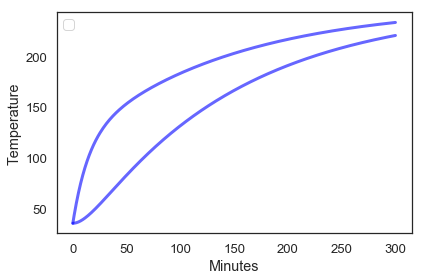

In [235]:
plot_results(results.T_inner, results.T_outer, 'blue')

In [236]:
def sweep_temp(system, slope_func, min_temp, max_temp, time):
    '''Sweep oven temperature
    
    min_temp: lowest temperature 
    max_temp: highest temperature
    
    Returns: Sweepseries
    '''
    
    temp_array = linspace(min_temp, max_temp, 5)
    sweep = SweepSeries()
    
    colors = ['red','orange','yellow','green','blue','purple']
    color_counter = 0
    
    for temp in temp_array:
        system=make_system(params,temp,275,time) #make_system(params, T_oven, T_init, t_end)
        results, details = run_ode_solver(system,slope_func,max_step=1)
        plot_results(results.T_inner, results.T_outer, colors[color_counter])
        color_counter += 1
        #sweep[temp] = results
    
    

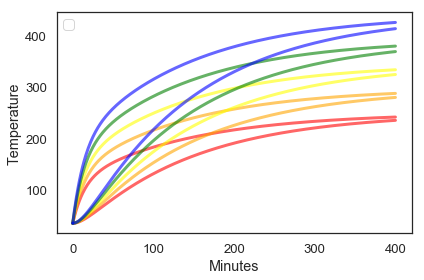

In [237]:
sweep_temp(system, slope_func, 394, 500, 400)